# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]:./examples/car_not_car.png
[image2]:./examples/HOG_example.jpg
[image3]:./examples/sliding_windows.jpg
[image4]:./examples/sliding_window.jpg
[image5]:./examples/bboxes_and_heat.png
[image6]:./examples/labels_map.png
[image7]:./examples/output_bboxes.png
[video1]:./project_video.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

#### Helper Functions

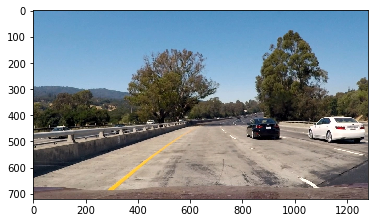

In [1]:
import cv2
import os
import glob
import numpy as np 
import matplotlib.pyplot as plt
from skimage.feature import hog

% matplotlib inline

def showImages(images, cols = 4, rows = 5, figsize=(15, 10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.tight_layout()
    
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if len(image.shape) > 2:# cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap='gray')
            ax.set_title(imagePathName)
            ax.axis('off')
            
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

testImage = cv2.imread("test_images/test1.jpg")
testImage = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB)

plt.imshow(testImage)

#### Helper Functions

Below are the helper functions from the Lecture

In [2]:
def colorspace_convert(image, colorspace):
    """
    Converts image to given colorspace

    Args:
        image (ndarray) - image array
        colorspace (str) - colorspace [HSV, LUV, HLS, YUV, RGB]

    Returns:
        feature_image (ndarray) - converted image
    """
    if colorspace != 'BGR':
        if colorspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif colorspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif colorspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif colorspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif colorspace == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        feature_image = np.copy(image)
    return feature_image

def get_spatial_features(image, colorspace='RGB', size=(32, 32)):
    """
    Computes Spatial features

    Args:
        image (ndarray) - image array
        colorspace (str) - colorspace to be used
        size (tuple) - width, height of spatial size

    Returns:
        features (ndarray) - spatial features
    """

    feature_image = colorspace_convert(image, colorspace)
    features = cv2.resize(feature_image, size).ravel()
    return features

def get_hog_features(image, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block),
                      block_norm='L2-Hys', transform_sqrt=False,
                      visualise=vis, feature_vector=feature_vec)

    # name returns explicitly
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return return_list

def get_hist_features(image, nbins=32, bins_range=(0, 256)):
    """
    Computes histogram features

    Args:
        image       (ndarray) - image array
        nbins       (int)     - number of bins
        bins_range  (tuple)   - histogram bin range

    Returns:
        rhist           (ndarray)  - histogram of 1st channel
        ghist           (ndarray)  - histogram of 2nd channel
        bhist           (ndarray)  - histogram of 3rd channel
        bin_centers     (int)      - centers of image histogram
        hist_features   (ndarray)  - histogram features
    """
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:, :, 0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:, :, 1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:, :, 2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def extract_features(images, colorspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
    Extracts all the features and concatenate them together

    Args:
        images          (list(str)) - list of imagepath
        colorspace      (str)       - color space to be used
        spatial_size    (tuple)     - (w, h) for spatial features
        hist_bins       (int)       - bins for histogram
        hist_range      (tuple)     - (min, max) range for histogram

    Returns:
        features (list) - list of features of each imagepath where all the features were concatenated
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for fname in images:
        # Read in each one by one
        image = cv2.imread(fname)
        # apply color conversion if other than 'RGB'
        feature_image = colorspace_convert(image, colorspace)
        # Apply bin_spatial() to get spatial color features
        spatial_features = get_spatial_features(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        rhist, ghist, bhist, bin_centers, hist_features = get_hist_features(feature_image, nbins=hist_bins, 
                                                                            bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate([spatial_features, hist_features, hog_features]))
        #features.append()

    return features

Number of images in class vehicle: 8792
Number of images in class non-vehicle: 8968


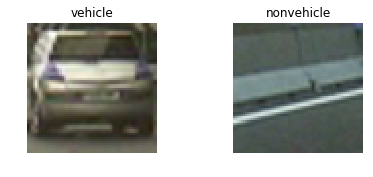

In [10]:
DATASET_ROOT = os.path.join(os.path.expanduser("~"), "workspace", "datasets", "vehicle_detection")
VEHICLE_IMAGEDIR = os.path.join(DATASET_ROOT, "vehicles")
NONVEHICLE_IMAGEDIR = os.path.join(DATASET_ROOT, "non-vehicles")

assert os.path.exists(VEHICLE_IMAGEDIR), "Vehicle image dataset not found at %s" % (VEHICLE_IMAGEDIR)
assert os.path.exists(NONVEHICLE_IMAGEDIR), "Vehicle image dataset not found at %s" % (NONVEHICLE_IMAGEDIR)


vehicleImageList = glob.glob(os.path.join(VEHICLE_IMAGEDIR, "*/*.png"))
nonvehicleImageList = glob.glob(os.path.join(NONVEHICLE_IMAGEDIR, "*/*.png"))

print("Number of images in class vehicle: %s" % (len(vehicleImageList)))
print("Number of images in class non-vehicle: %s" % (len(nonvehicleImageList)))

import random
random.seed(10)
randindex = random.randint(0, len(vehicleImageList))

sampleVehicleImage = cv2.imread(vehicleImageList[randindex])
sampleNonVehicleImage = cv2.imread(nonvehicleImageList[randindex])

showImages([("vehicle", sampleVehicleImage), ("nonvehicle", sampleNonVehicleImage)], 2, 1, figsize=(5, 2))

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

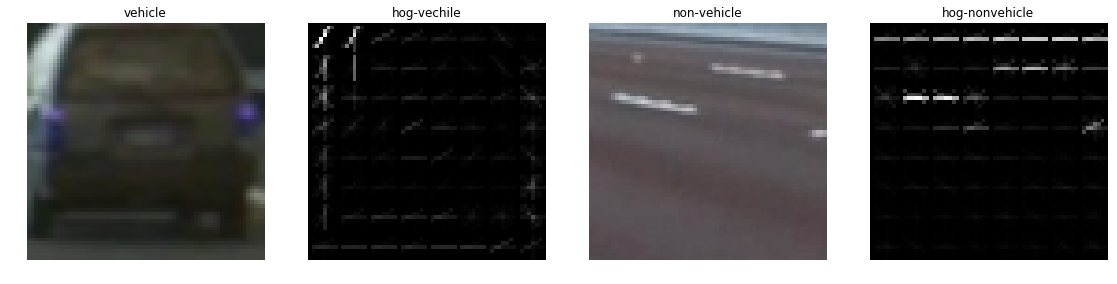

In [59]:
# VEHICLE HOG FEATURES
sampleVehicleYCrCbImage = cv2.cvtColor(sampleVehicleImage, cv2.COLOR_BGR2YCrCb)

sampleHogFeatures, sampleHogVis = get_hog_features(sampleVehicleYCrCbImage[:,:,0], orient=8, 
                                                   pix_per_cell=8, cell_per_block=2, 
                                                   vis=True, feature_vec=True)
# NOT-VEHICLE HOG FEATURES
sampleNonVehicleYCrCbImage = cv2.cvtColor(sampleNonVehicleImage, cv2.COLOR_BGR2YCrCb)

sampleHogFeatures2, sampleHogVis2 = get_hog_features(sampleNonVehicleYCrCbImage[:,:,0], orient=8, 
                                                     pix_per_cell=8, cell_per_block=2, 
                                                     vis=True, feature_vec=True)
showImages([("vehicle", sampleVehicleImage), ("hog-vechile", sampleHogVis), 
            ("non-vehicle", sampleNonVehicleImage), ("hog-nonvehicle", sampleHogVis2)], 4, 1, figsize=(15, 5))

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...


In [12]:
car_features = extract_features(vehicleImageList, colorspace='YUV', hog_channel='ALL')
notcar_features = extract_features(nonvehicleImageList, colorspace='YUV', hog_channel='ALL')

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

X = np.vstack((car_features, notcar_features)).astype(np.float64)  
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [14]:
import time

# load classifier LinearSVC
svc = LinearSVC()
startTime = time.time()

svc.fit(X_train, y_train)

print(round(time.time() - startTime, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


18.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9862


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

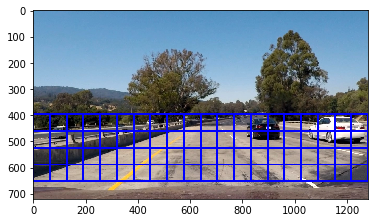

In [31]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0] * 0.55), int(image.shape[0] * 0.95)], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [41]:


image = cv2.imread("test_images/test1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0] * 0.55), int(image.shape[0] * 0.95)], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YUV', 
                        spatial_size=(16, 16), hist_bins=16, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel='ALL', spatial_feat=True, 
                        hist_feat=True, hog_feat=True)           

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)


ValueError: setting an array element with a sequence.

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]



In [42]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(sampleVehicleImage[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, bboxes)

# Apply threshold to help remove false positives
threshold = 1
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

NameError: name 'bboxes' is not defined

---
### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here's a [link to my video result](./project_video.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]


### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  


---
### Extras

#### 1. Perform Object Detection with modern approach of Deep Learning

As for recent trends, Deep Leanring is outperforming Traditional Computer Vision methods in complex tasks of Classification and Object Detections.

Here as part of assignment I thought to analyzing it by myself and get myself convinced how Deep Learning models outperform Computer Vision approach described above.

For this I mainly consume, TensorFlow(TM) for inferencing pretrained model for Object Detection and model called Single Shot Detection trained on MSCOCO dataset having MobileNetv2 Architecture for classification block.

In [16]:
import os
import cv2
import tensorflow as tf

print("OpenCV version: %s" % (cv2.__version__))
print("TensorFlow version: %s" % tf.__version__)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


OpenCV version: 3.4.1
TensorFlow version: 1.8.0


In [17]:
from six.moves import urllib
import tarfile
import sys

def maybe_download_and_extract(data_url, clean_dir=False):
    """
    Download and extract model tar file.

    If the pretrained model we're using doesn't already exist, this function
    downloads it from the TensorFlow.org website and unpacks it into a directory.

    Args:
        data_url: Web location of the tar file containing the pretrained model.

    Returns:
        dest_directory: Destination directory where files were extracted
    """
    dest_directory = os.path.join(os.path.abspath(os.path.curdir), "tmp")
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    if clean_dir:
        for item in os.listdir(dest_directory):
            if item.endswith(".pb") or item.endswith(".txt"):
                os.remove(os.path.join(dest_directory, item))

    filename = data_url.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):

        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' %
                             (filename,
                              float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()

        filepath, _ = urllib.request.urlretrieve(data_url, filepath, _progress)
        print("")
        statinfo = os.stat(filepath)
        print('Successfully downloaded %s %d bytes.' % (filename, statinfo.st_size))
    else:
        print('Not downloading files, model gzip already present in disk')

    print('Extracting file from %s' % filepath)
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)
    return dest_directory

# Download SSD MobileNet v2 COCO trained model available from TensorFlow Model Zoo
maybe_download_and_extract("http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz")

>> Downloading ssd_mobilenet_v2_coco_2018_03_29.tar.gz 13.2%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading ssd_mobilenet_v2_coco_2018_03_29.tar.gz 34.1%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading ssd_mobilenet_v2_coco_2018_03_29.tar.gz 55.1%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading ssd_mobilenet_v2_coco_2018_03_29.tar.gz 76.1%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Downloading ssd_mobilenet_v2_coco_2018_03_29.tar.gz 97.0%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##### Load Pretrained Graph

In [18]:
# load pretrained graph using TF api
with tf.gfile.GFile("tmp/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb", "rb") as fp:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(fp.read())
    
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def)
    
tensor_names = [op.name for op in graph.get_operations()]
print("first 5 layers:\n", tensor_names[:5], "\nlast 5 layers:\n", tensor_names[-5:])

first 5 layers:
 ['import/Const', 'import/image_tensor', 'import/ToFloat', 'import/Preprocessor/map/Shape', 'import/Preprocessor/map/TensorArrayUnstack/Shape'] 
last 5 layers:
 ['import/Postprocessor/ToFloat_3', 'import/num_detections', 'import/add/y', 'import/add', 'import/detection_classes']


In [20]:
# Obtain Tensor object fetched from it's name in graph
image_tensor = graph.get_tensor_by_name("import/image_tensor:0")  # input image placeholder
detection_boxes = graph.get_tensor_by_name("import/detection_boxes:0")  # bounding boxes (ymin, xmin, ymax, xmax)
detection_scores = graph.get_tensor_by_name("import/detection_scores:0")  # score (float)
detection_classes = graph.get_tensor_by_name("import/detection_classes:0")  # classid (int)
num_detections = graph.get_tensor_by_name("import/num_detections:0")  # number of detections

##### Infer image

In [21]:
import numpy as np
# Inference on test image
img = cv2.imread("test_images/test1.jpg")
with tf.Session(graph=graph) as sess:
    boxes, scores, classes, n = sess.run([detection_boxes, detection_scores, detection_classes, num_detections], 
                                          feed_dict={image_tensor: np.expand_dims(img, axis=0)})
boxes = np.squeeze(boxes)
scores = np.squeeze(scores)
classes = np.squeeze(classes).astype(np.int32)
n = np.squeeze(n).astype(np.int32)
print(boxes.shape)
print(scores.shape)
print(classes.shape)
print(n)

(100, 4)
(100,)
(100,)
2


##### Draw Bounding Boxes

In [22]:
# Draw boxes on image
vis = img.copy()
height, width = vis.shape[:2]

for i in range(boxes.shape[0]):
    classid = classes[i] - 1

    if scores[i] > 0.25:    
        ymin, xmin, ymax, xmax = boxes[i]
        
        x1 = int(xmin * width)
        y1 = int(ymin * height)
        x2 = int(xmax * width)
        y2 = int(ymin * height)
    
        cv2.rectangle(vis, (x1, y1), (x2, y2), (255, 0, 100), 4)

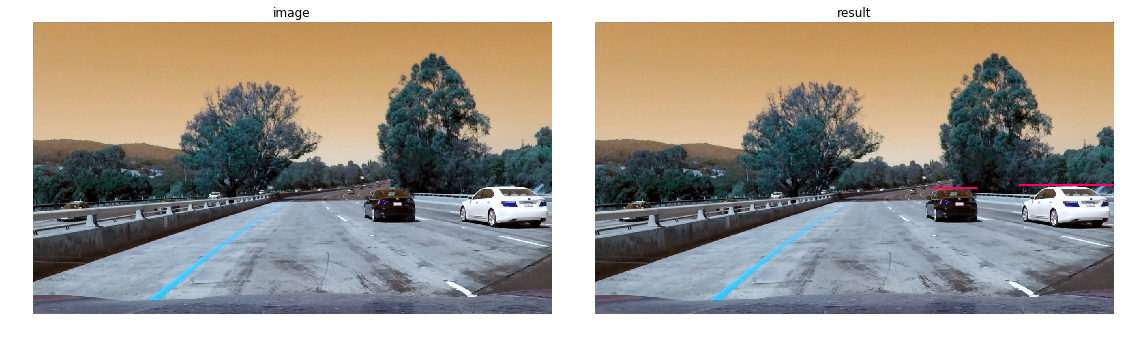

In [23]:
showImages([("image", img), ("result", vis)], 2, 1)